### Load required libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

import xarray as xr
import numpy as np
import pandas as pd

from collections import defaultdict

from numba import njit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as pe

### Define dicts to access data

In [2]:
#####################################################
# cyclone specific data
#####################################################
# channel_Xkm_0001: control simulations
# channel_Xkm_0002: +4K, qv consistent with T
# channel_Xkm_0003: +4k, qv from control
# channel_Xkm_0004: +temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0005: +tropical temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0006: +polar temperature anomaly from MPI-ESM1-2-LR far future

# Note that the  2-km experiments contain outputs every 6 hrs
# Note that the 80-km experiments contain outputs every 1 hrs


expname = {
      1: 'CTL',    
      2: 'T+4K',
      3: 'T+4K_RH-',
      4: 'T+anom',
      5: 'T+TRanom',
      6: 'T+POanom'
         }

exp80 = { 
      1:'channel_80km_0001',
      2:'channel_80km_0002',
      3:'channel_80km_0003',
      4:'channel_80km_0004',
      5:'channel_80km_0005',
      6:'channel_80km_0006',
      }

exp2 = { 
      1:'channel_2km_0001',
      2:'channel_2km_0002',
      3:'channel_2km_0003',
      4:'channel_2km_0004',
      5:'channel_2km_0005',
      6:'channel_2km_0006',
      }


### Set experiments to load data for

In [3]:
experiments  = [exp2[1],exp2[2],exp2[3],exp2[4],exp2[5],exp2[6],exp80[1],exp80[2],exp80[3],exp80[4],exp80[5],exp80[6]]

### Set domain parameters

In [4]:
# desired latitudinal extent of data
latmin = 20
latmax = 70

# longitudinal extent of data
lon_min=12.5
lon_ext=51
lon_max=lon_min+lon_ext

### Read in track data

In [5]:
def read_track_data(exp,track_dur,track_lon,track_lat,track_pmin):

    # path
    path_track = '/work/bb1152/Module_A/A6_CyclEx/pp_data/cyclone_tracks/'

    df_track = pd.read_csv(path_track+'Track_for_'+exp+'_6hrly_1x1latlon.csv')
    
    # extract vars of interest
    track_dur[exp]  = df_track['time']+1
    track_lon[exp]  = df_track['lon']
    track_lat[exp]  = df_track['lat']
    track_pmin[exp] = df_track['pmin']
    
    return track_dur,track_lon,track_lat,track_pmin

In [6]:
track_dur  = {}
track_lon  = {}
track_lat  = {}
track_pmin = {}

for exp in experiments:
    track_dur,track_lon,track_lat,track_pmin = read_track_data(exp,
                                                               track_dur,
                                                               track_lon,
                                                               track_lat,
                                                               track_pmin)

### Determine required shift of data in longitudinal direction for centering on location of pmin

In [7]:
def get_lon_shift(cen_lon):
    
    shift = lon_min + lon_ext/2 - cen_lon

    return shift

In [8]:
shift = defaultdict(dict)

for exp in experiments:
    shift[exp] = get_lon_shift(track_lon[exp])
    #print(shift[exp])

### Load raw simulation output

####  Helper function for loading data

In [9]:
def load_iconsimulation(expid):
    
    print('Working on loading data for', expid)
    # set path to data
    path  = '/work/bb1152/Module_A/A6_CyclEx/sim_data/production'
    # set path to grid
    gridpath = '/work/bb1152/Module_A/A6_CyclEx/input_data/'
    # set grid file
    
    # 2d datasets
    if (expid in list(exp80.values())):
        fname = path+'/'+expid+'/raw_data/icon-atm2d_ML_202101*Z.nc'
        gridfile = 'Channel_4000x9000_80000m_with_boundary.nc'
    else:
        fname = path+'/'+expid+'/icon-atm2d_ML_202101*Z.nc'
        gridfile = 'Channel_4000x9000_2500m_with_boundary.nc'
    print(fname)
    ds_2d = xr.open_mfdataset(fname).rename({'plev': 'plev_1'})
    
    # 3d datasets
    fname = path+'/'+expid+'/interpol_850hPa_qv_u_v_native/icon-qv_u_v_850hPa_202101*Z.nc'
    print(fname)
    ds_3d = xr.open_mfdataset(fname)
    
    # grid dataset
    fname = gridpath+gridfile
    print(fname)
    ds_grid = ( xr.open_dataset(fname)
               [['cell_area','clat','clon','clon_vertices','clat_vertices',
                 'vlon','vlat','vertex_of_cell', 'vertex']].rename({'cell': 'ncells'}) ) 
    # we need to subtract -1 from vertex_of_cell as python starts counting at 0, but fortran starts at 1
    ds_grid['vertex_of_cell'] = ds_grid['vertex_of_cell'] - 1 
    
    # merge datasets
    ds = xr.merge([ds_2d, ds_3d, ds_grid])
        
    # convert grid from radians to degrees
    ds['clon'] = np.rad2deg(ds['clon'])
    ds['clat'] = np.rad2deg(ds['clat'])
    ds['vlon'] = np.rad2deg(ds['vlon'])
    ds['vlat'] = np.rad2deg(ds['vlat'])
    ds['clon_vertices'] = np.rad2deg(ds['clon_vertices'])
    ds['clat_vertices'] = np.rad2deg(ds['clat_vertices'])
    
    return ds

### Load data

In [10]:
ds = {}

for exp in experiments:
    ds[exp] = load_iconsimulation(exp)

Working on loading data for channel_2km_0001
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0001/icon-atm2d_ML_202101*Z.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0001/interpol_850hPa_qv_u_v_native/icon-qv_u_v_850hPa_202101*Z.nc
/work/bb1152/Module_A/A6_CyclEx/input_data/Channel_4000x9000_2500m_with_boundary.nc
Working on loading data for channel_2km_0002
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0002/icon-atm2d_ML_202101*Z.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0002/interpol_850hPa_qv_u_v_native/icon-qv_u_v_850hPa_202101*Z.nc
/work/bb1152/Module_A/A6_CyclEx/input_data/Channel_4000x9000_2500m_with_boundary.nc
Working on loading data for channel_2km_0003
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0003/icon-atm2d_ML_202101*Z.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0003/interpol_850hPa_qv_u_v_native/icon-qv_u_v_850hPa_202101*Z.nc
/work/bb1152/Module_A/

### Select required variables and timesteps

In [12]:
for exp in experiments:
    
    # Select required variables
    ds[exp] = ds[exp][['pres_msl',
                       'tot_prec',
                       'u_10m',
                       'v_10m',
                       'qv', # at 850 hPa
                       #'u', # at 850 hPa
                       #'v', # at 850 hPa
                       'vlon','vlat','vertex_of_cell','clon_vertices']]
    
    # Adjust time axis
    ds[exp]['time'] = ds[exp]['time']-20210100
    
    # Reduce to 6-hourly data for 80km CTL sim
    if (exp in list(exp80.values())):
        ds[exp] = ds[exp].sel(time=np.arange(1,10.1,0.25))
        
    # Add 6-hourly precipiation to dataset
    # Prec. in kg m-2 
    ds[exp]['prec_6hrly'] = ds[exp]['tot_prec'].diff(dim='time')
    
    # Add 10m wind
    ds[exp]['wind_10m'] = np.sqrt(ds[exp]['u_10m'].isel(height=0)**2 + ds[exp]['v_10m'].isel(height=0)**2)
    
    # Add 850 hPa wind
    #ds[exp]['wind_850hPa'] = np.sqrt(ds[exp]['u'].isel(plev=0)**2 + ds[exp]['v'].isel(plev=0)**2)
    
    # Select desired timesteps
    #ds[exp] = ds[exp].sel(time=t_plot[exp])
    #ds[exp] = ds[exp].sel(time=np.arange(3,9,0.25))

### Reduce latitudinal range of data

In [13]:
def reduce_latrange(ds,latmin,latmax):
    icells = np.where((ds.clat<latmax) & (ds.clat>latmin))[0]
    ds = ds.isel(ncells=icells)
    
    return ds

In [14]:
def reduce_lonrange(ds,lonmin,lonmax):
    icells = np.where((ds.clon<lonmax) & (ds.clon>lonmin))[0]
    ds = ds.isel(ncells=icells)
    
    return ds

In [15]:
for exp in experiments:
    ds[exp] = reduce_latrange(ds[exp],latmin,latmax)

### Remove triangles that connect eastern and western domain boundary

In [16]:
@njit()
def get_indices_regular_triangles(clon_vertices):
    
    # determine number of triangles
    
    ntriang = np.shape(clon_vertices)[0]
    
    # required to make all values integer
    icells_regular = np.full(ntriang,-1,dtype=np.int64)
    
    for i in range(0,ntriang):
        if np.any(np.abs(clon_vertices[i]-np.mean(clon_vertices[i]))<1):
            icells_regular[i] = int(i)

    # required to remove first value, which is required to make all values integer
    icells_regular = icells_regular[np.where(icells_regular>=0)]
    
    return icells_regular

In [17]:
def remove_skewed_triangles(ds):

    # select indices
    icells_regular = get_indices_regular_triangles(ds.clon_vertices.to_numpy())
    
    ds_out = ds.isel(ncells=icells_regular)
    
    return ds_out

In [18]:
ds_red = defaultdict(dict)

for exp in experiments:
    ds_red[exp] = remove_skewed_triangles(ds[exp])

### Modify the skewed triangles

In [19]:
@njit()
def get_indices_skewed_triangles(clon_vertices):
    
    # determine number of triangles
    
    ntriang = np.shape(clon_vertices)[0]
    
    # required to make all values integer
    icells_skewed = np.full(ntriang,-1,dtype=np.int64)
    
    for i in range(0,ntriang):
        if np.any(np.abs(clon_vertices[i]-np.mean(clon_vertices[i]))>1):
            icells_skewed[i] = int(i)

    # required to remove first value, which is required to make all values integer
    icells_skewed = icells_skewed[np.where(icells_skewed>=0)]
    
    return icells_skewed

In [20]:
def modify_skewed_triangles(ds,shift):

    # 1. step: select skewed triangles
    icells_skewed = get_indices_skewed_triangles(ds.clon_vertices.to_numpy())
    
    ds_out = ds.isel(ncells=icells_skewed)
    
    # 2. step: modify skewed triangles depending on whether we need to extend domain towards west or east
    
    for var in ['vlon','clon']:
        if shift < 0:
            ds_out[var] = ds_out[var].where(ds_out[var]>40,ds_out[var]+lon_ext)
        elif shift > 0:
            ds_out[var] = ds_out[var].where(ds_out[var]<40,ds_out[var]-lon_ext)
    
    return ds_out

In [21]:
ds_skewed = defaultdict(dict)

for exp in experiments:
    for t in np.arange(0,37,1):       #t=0 -->time=1; t=8 --> time=3; t=32 --> time=9
        ds_skewed[exp] = modify_skewed_triangles(ds[exp],shift[exp][t])

### Add a second domain to the west or east depending on shift

In [22]:
def lon_shift_ds(ds,shift,shift_vortices=True):
    
    if shift_vortices:
        vars_to_shift = ['vlon','clon']
    else:
        vars_to_shift = ['clon']
    
    for var in vars_to_shift:
        ds[var] = ds[var] + shift
    
    return ds

In [23]:
def create_shifted_domain_ww_or_ew(ds,shift):
    
    ds_shift = ds.copy(deep=True)

    # Add domain depending on whether we need to extend domain towards west or east
    
    if shift < 0:
        to_shift = lon_ext
    elif shift > 0:
        to_shift = -1*lon_ext
        
    ds_shift = lon_shift_ds(ds_shift,to_shift)
        
    return ds_shift

In [24]:
ds_shift = defaultdict(dict)

for exp in experiments:
    for t in np.arange(0,37,1):  
        ds_shift[exp] = create_shifted_domain_ww_or_ew(ds_red[exp],shift[exp][t])

### Concatenate datasets for contour plots (does not work with triplot)

In [25]:
vars_to_concat = ['pres_msl','wind_10m']

In [26]:
ds_concat = defaultdict(dict)

for exp in experiments:
        ds_concat[exp] = xr.concat([ds_red[exp][vars_to_concat],
                                       ds_skewed[exp][vars_to_concat],
                                       ds_shift[exp][vars_to_concat]],
                                      dim='ncells')

### Centering on location of pmin

In [27]:
for exp in experiments:
    for t in np.arange(0,37,1):  
        ds_concat[exp]  = lon_shift_ds(ds_concat[exp],shift[exp][t],
                                     shift_vortices=False)
        #ds_shift[exp]   = lon_shift_ds(ds_shift[exp],shift[exp][t])
        #ds_skewed[exp]  = lon_shift_ds(ds_skewed[exp],shift[exp][t])
        ds_red[exp]     = lon_shift_ds(ds_red[exp],shift[exp][t])
        


### Plotting.

Check whether below plotting style can be kept for final manuscript figures.

In [28]:
import matplotlib.style as mplstyle
mplstyle.use('fast')
from matplotlib import gridspec

In [29]:
perc=99
tp_ext     = {}
wdsp_ext   = {}
tp_avg     = {}
wdsp_avg   = {}
tp_cavg    = {}
wdsp_cavg  = {}
tp_cgrid   = {}
wdsp_cgrid = {}
pminc      = {}

qv_avg     = {}

deeprate   = {}
tpavg_change   = {}
wdspavg_change = {}

def avg_conditional(speed,threshold):
    s = np.array(speed)
    positives = s > threshold
    if positives.any():
        return s[positives].mean()
    else:
        return np.nan



for exp in experiments:
    wdspext  = np.full(len(track_dur[exp]),np.nan,dtype=float)
    tpext    = np.full(len(track_dur[exp]),np.nan,dtype=float)
    wdspavg  = np.full(len(track_dur[exp]),np.nan,dtype=float)
    tpavg    = np.full(len(track_dur[exp]),np.nan,dtype=float)
    wdspcavg = np.full(len(track_dur[exp]),np.nan,dtype=float)
    tpcavg   = np.full(len(track_dur[exp]),np.nan,dtype=float)
    wdspcgrid   = np.full(len(track_dur[exp]),np.nan,dtype=float)
    tpcgrid   = np.full(len(track_dur[exp]),np.nan,dtype=float)
    qvavg    = np.full(len(track_dur[exp]),np.nan,dtype=float)
    
    deeprate0= np.full(len(track_dur[exp]),np.nan,dtype=float)
    pmin  = track_pmin[exp].to_numpy()
    for tindex in np.arange(8,32,1):  
        #lon1 = track_lon[exp][tindex]-20
        #lon2 = track_lon[exp][tindex]+20
        #print(lon1, lon2)
        #lat1 = track_lat[exp][tindex]-20
        #lat2 = track_lat[exp][tindex]+20
        x = ds_red[exp].isel(time= tindex)
        y = ds_concat[exp].isel(time= tindex)
        #x0  = reduce_lonrange(x00, lon1, lon2)
        #x   = reduce_latrange(x0,  lat1, lat2)
        #y0  = reduce_lonrange(y00, lon1, lon2)
        #y   = reduce_latrange(y0,  lat1, lat2)
        tpext[tindex]   = np.percentile(x['prec_6hrly'],perc)
        wdspext[tindex] = np.percentile(y['wind_10m'],perc)
        
        
        if exp==exp80[1]:
            print(pmin[tindex],np.percentile(y['wind_10m'],50))
        #tpavg[tindex]   = np.average(x['prec_6hrly'], weights=(x['prec_6hrly'] > 0))
        #wdspavg[tindex] = np.average(y['wind_10m'], weights=(y['wind_10m'] > 20))   
        
        tpavg[tindex]    = np.average(x['prec_6hrly'])
        wdspavg[tindex]  = np.average(y['wind_10m'])  
        
        qvavg[tindex]    = np.average(x['qv'])
        
        tpcavg[tindex]    = avg_conditional(x['prec_6hrly'], 0.0)
        wdspcavg[tindex]  = avg_conditional(y['wind_10m'], 13)  
        
        tpcgrid[tindex]   = np.count_nonzero(x['prec_6hrly']> 0.0)/len(x['prec_6hrly'])
        wdspcgrid[tindex] = np.count_nonzero(y['wind_10m']> 13)/len(y['wind_10m'])
        
        deeprate0[tindex] = (pmin[tindex+1]-pmin[tindex])
    
    tp_ext[exp] = tpext
    wdsp_ext[exp] = wdspext
    tp_avg[exp] = tpavg
    wdsp_avg[exp] = wdspavg
    tp_cavg[exp] = tpcavg
    wdsp_cavg[exp] = wdspcavg
    deeprate[exp] = deeprate0
    
    tp_cgrid[exp] = tpcgrid
    wdsp_cgrid[exp] = wdspcgrid
    
    pminc[exp] = pmin
    
    tpavg_cha   = np.full(len(track_dur[exp]),np.nan,dtype=float)
    wdspavg_cha = np.full(len(track_dur[exp]),np.nan,dtype=float)
    for t in np.arange(8,32,1):  
        tpavg_cha[t]   = tpavg[t]-tpavg[t-1]
        wdspavg_cha[t] = wdspavg[t]-wdspavg[t-1]
        
    tpavg_change[exp]   = tpavg_cha
    wdspavg_change[exp] = wdspavg_cha
    
#print(tp_ext['channel_2km_0002'])
#print(tp_ext['channel_80km_0002'])

996.4685668945312 1.2770183086395264
994.9822387695312 1.5759894847869873
992.636962890625 1.8897477388381958
989.0822143554688 1.7800149321556091
984.9994506835938 2.3074820041656494
979.1090698242188 2.716309070587158
972.468017578125 3.1097052097320557
966.6602172851562 3.715205669403076
963.8688354492188 4.338613033294678
961.5752563476562 5.12698221206665
960.7135009765624 6.2694621086120605
958.72412109375 7.284083843231201
956.399169921875 8.28565502166748
955.298095703125 9.486526012420654
953.98876953125 10.562593460083008
950.4031372070312 11.681373596191406
945.8432006835938 12.510716438293457
943.6115112304688 12.876812934875488
942.3345336914062 12.995664119720459
943.68701171875 13.156136512756348
945.4607543945312 13.232722759246826
946.3692016601562 13.318985939025879
945.9135131835938 13.578328132629395
946.26611328125 13.68943977355957


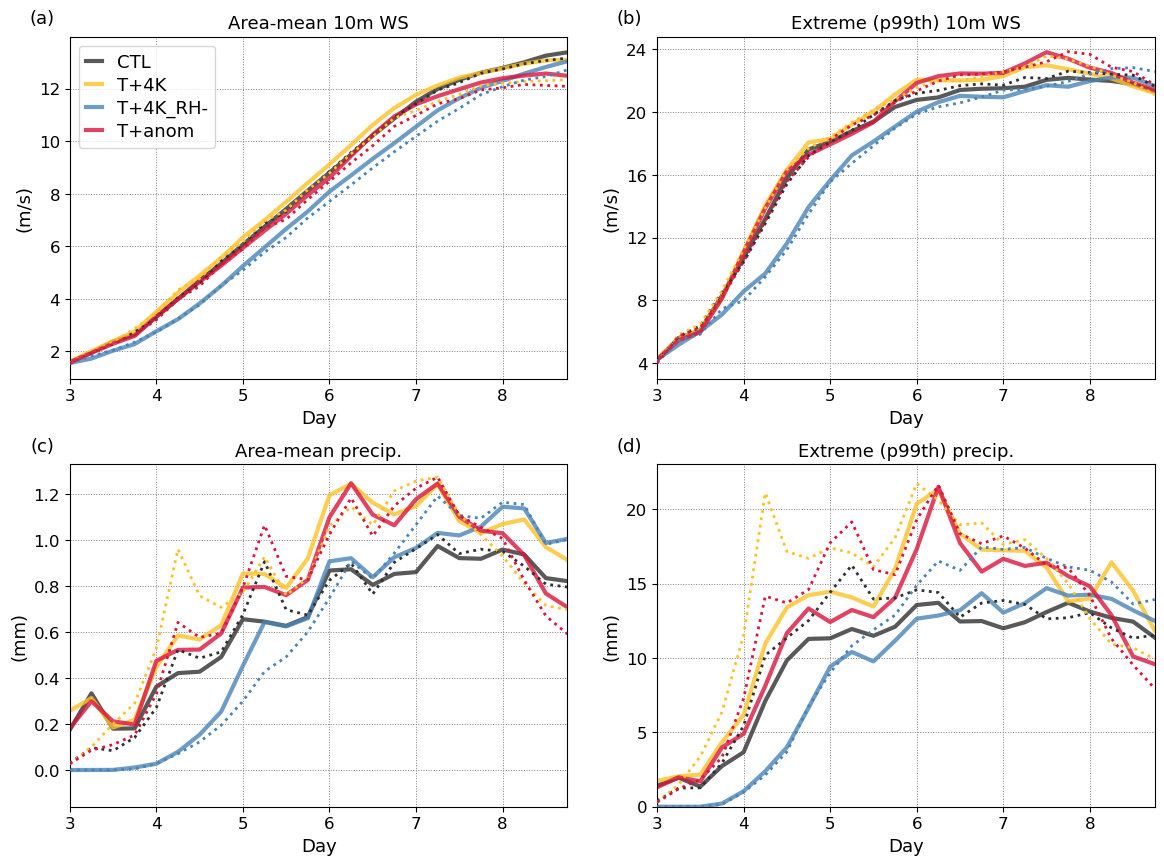

In [30]:
# FOR SUPPLEMENTARY MATERIAL ================================

colors2={0:'white',1:'#FFC125',2:'#4984b8',3:'crimson',4:'yellowgreen',5:'mediumpurple'}

#colors={1:'k',2:'#FFC125',3:'#4984b8',4:'crimson',5:'gold',6:'mediumseagreen'}
colors={0:'#303030',1:'#FFC125',2:'#4984b8',3:'crimson',4:'yellowgreen',5:'mediumpurple'}

colorsedge={0:'k',1:'k',2:'k',3:'k',4:'k',5:'k',6:'k'}
#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}


expname = ['CTL', 'T+4K', 'T+4K_RH-','T+anom','T+TRanom','T+POanom']

#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}
fs=12

plt.rcParams['savefig.facecolor']='white'
fig = plt.figure(figsize=(14, 10))


ax1 = plt.subplot(2,2,1)
for i in range(0,6,1): # 2km
    #if i > 3:
    #    plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    if i<=3: 
        plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1,zorder=100)
for i in range(6,12,1): # 80km
    #if i > 3+6:
    #    plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    if i<= 3+6:
        plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i-6],linewidth=3,alpha=0.8,label=expname[i-6]) 
        
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
#plt.ylim(1,13.8)
plt.xlabel('Day',fontsize=13)
plt.ylabel('(m/s)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Area-mean 10m WS', fontsize=13)
#plt.title('Averaged 850-m wdsp in 40x40 domain', fontsize=14)
plt.text(-0.03, 1.08, '(a)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
ax1.xaxis.set_ticks(np.arange(3, 9, 1))
plt.legend(loc="upper left",fontsize=13,labelspacing=0.28,handlelength=0.9)



ax1 = plt.subplot(2,2,2)
#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(0,6,1): # 2km
    #if i > 3:
    #    plt.plot(track_dur[experiments[i]],wdsp_ext[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    if i<=3: 
        plt.plot(track_dur[experiments[i]],wdsp_ext[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1,zorder=100)
for i in range(6,12,1): # 80km
    #if i > 3+6:
    #    plt.plot(track_dur[experiments[i]],wdsp_ext[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    if i<= 3+6:
        plt.plot(track_dur[experiments[i]],wdsp_ext[experiments[i]],color=colors[i-6],linewidth=3,alpha=0.8,label=expname[i-6]) 
      
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
plt.ylim(3,24.8)
plt.xlabel('Day',fontsize=13)
plt.ylabel('(m/s)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Extreme (p99th) 10m WS', fontsize=13)
#plt.title('P98th 850-hPa wdsp in 40x40 domain', fontsize=14)
plt.text(-0.03, 1.08, '(b)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
#plt.legend(loc="lower right",fontsize=12,labelspacing=0.28,handlelength=0.9)
ax1.xaxis.set_ticks(np.arange(3, 9, 1))
ax1.yaxis.set_ticks(np.arange(4, 25, 4))
#=============================================

ax1 = plt.subplot(2,2,3)

for i in range(0,6,1): # 2km
    #if i > 3:
    #    plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    if i <=3: 
        ax1.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1,zorder=100)
       # ax1.plot(track_dur[experiments[i]],tp_cavg[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1,zorder=100)
for i in range(6,12,1): # 80km
    #if i > 3+6:
    #    plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    if i<= 3+6:
        ax1.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i-6],linewidth=3,alpha=0.8,label=expname[i-6])
        #ax1.plot(track_dur[experiments[i]],tp_cavg[experiments[i]],color=colors[i-6],linewidth=3,alpha=0.8,label=expname[i-6])
        #print('expname',expname[i-6],'max tp_avg',tp_avg[experiments[i]])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
plt.ylim(-0.16, 1.33)
plt.xlabel('Day',fontsize=13)
plt.ylabel('(mm)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Area-mean precip.', fontsize=13)
plt.text(-0.03, 1.08, '(c)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
ax1.xaxis.set_ticks(np.arange(3, 9, 1))


ax1 = plt.subplot(2,2,4)
#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(0,6,1): # 2km
    #if i > 3:
    #    plt.plot(track_dur[experiments[i]],tp_ext[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    if i <= 3: 
        plt.plot(track_dur[experiments[i]],tp_ext[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1,zorder=100)
for i in range(6,12,1): # 80km
    #if i > 3+6:
    #    plt.plot(track_dur[experiments[i]],tp_ext[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    if i<= 3+6:
        plt.plot(track_dur[experiments[i]],tp_ext[experiments[i]],color=colors[i-6],linewidth=3,alpha=0.8,label=expname[i-6]) 
        
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
plt.ylim(0, 23)
plt.xlabel('Day',fontsize=13)
plt.ylabel('(mm)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Extreme (p99th) precip.', fontsize=13)
plt.text(-0.03, 1.08, '(d)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
ax1.xaxis.set_ticks(np.arange(3, 9, 1))



plt.subplots_adjust(hspace = 0.25, wspace=0.18)

#plt.title('Deepening rate of the cyclone center (Semi-Lagragian)', fontsize=14)
plt.savefig('FigR5.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()

expname CTL max wdsp_ext [        nan         nan         nan         nan         nan         nan
         nan         nan  4.20097256  5.60497904  6.10525799  8.30296222
 10.73606205 13.19887066 15.80016994 17.61554909 18.12707901 18.78330231
 19.39352608 20.32913589 20.77698708 20.93426704 21.40883446 21.4861412
 21.51881599 21.6164856  22.0513916  22.1803112  22.06766129 21.97942162
 21.78466034 21.29546165         nan         nan         nan         nan
         nan]
expname T+4K max wdsp_ext [        nan         nan         nan         nan         nan         nan
         nan         nan  4.28940964  5.56195974  6.1576084   8.18892765
 11.11368509 14.05153843 16.32317162 18.06819534 18.2918129  19.20609856
 20.04108429 21.1280098  22.06321335 22.02903175 22.02145767 22.04923695
 22.29904503 22.85494614 22.98409843 22.72951126 22.44223976 22.14228821
 21.64369392 21.21264839         nan         nan         nan         nan
         nan]
expname T+4K_RH- max wdsp_ext [        nan    

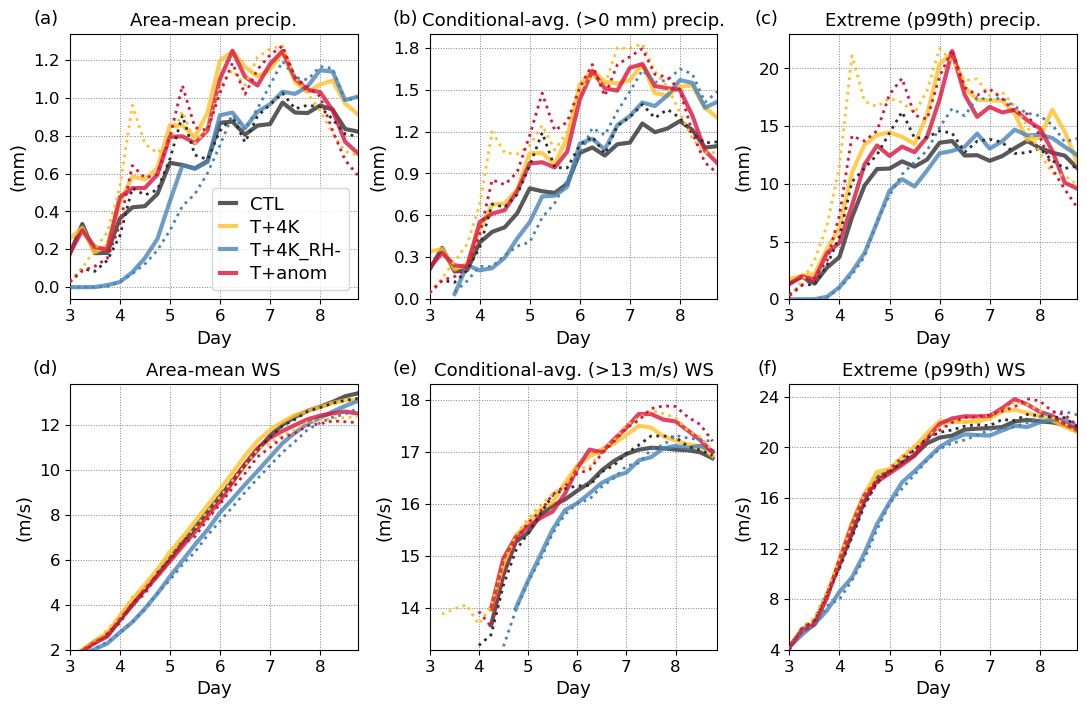

In [37]:
# FOR SUPPLEMENTARY MATERIAL ================================

colors2={0:'white',1:'#FFC125',2:'#4984b8',3:'crimson',4:'yellowgreen',5:'mediumpurple'}

#colors={1:'k',2:'#FFC125',3:'#4984b8',4:'crimson',5:'gold',6:'mediumseagreen'}
colors={0:'#303030',1:'#FFC125',2:'#4984b8',3:'crimson',4:'yellowgreen',5:'mediumpurple'}

colorsedge={0:'k',1:'k',2:'k',3:'k',4:'k',5:'k',6:'k'}
#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}


#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}
fs=12

plt.rcParams['savefig.facecolor']='white'
fig = plt.figure(figsize=(13, 8))


ax1 = plt.subplot(2,3,4)
for i in range(0,6,1): # 2km
    #if i > 3:
    #    plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    if i<=3: 
        plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1,zorder=100)
for i in range(6,12,1): # 80km
    #if i > 3+6:
    #    plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    if i<= 3+6:
        plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i-6],linewidth=3,alpha=0.8,label=expname[i-6]) 
        
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
plt.ylim(2,13.8)
plt.xlabel('Day',fontsize=13)
plt.ylabel('(m/s)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Area-mean WS', fontsize=13)
#plt.title('Averaged 850-m wdsp in 40x40 domain', fontsize=14)
plt.text(-0.04, 1.09, '(d)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
ax1.xaxis.set_ticks(np.arange(3, 9, 1))


ax1 = plt.subplot(2,3,5)
for i in range(0,6,1): # 2km
    #if i > 3:
    #    plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    if i<=3: 
        plt.plot(track_dur[experiments[i]],wdsp_cavg[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1,zorder=100)
for i in range(6,12,1): # 80km
    #if i > 3+6:
    #    plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    if i<= 3+6:
        plt.plot(track_dur[experiments[i]],wdsp_cavg[experiments[i]],color=colors[i-6],linewidth=3,alpha=0.8,label=expname[i-6]) 
        #print('expname',expname[i-6],'max wdsp_avg',wdsp_cavg[experiments[i]])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.85)
plt.ylim(13.2,18.3)
plt.xlabel('Day',fontsize=13)
plt.ylabel('(m/s)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Conditional-avg. (>13 m/s) WS', fontsize=13)
#plt.title('Averaged 850-m wdsp in 40x40 domain', fontsize=14)
plt.text(-0.04, 1.09, '(e)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
ax1.xaxis.set_ticks(np.arange(3, 9, 1))


ax1 = plt.subplot(2,3,6)
#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(0,6,1): # 2km
    #if i > 3:
    #    plt.plot(track_dur[experiments[i]],wdsp_ext[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    if i<=3: 
        plt.plot(track_dur[experiments[i]],wdsp_ext[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1,zorder=100)
for i in range(6,12,1): # 80km
    #if i > 3+6:
    #    plt.plot(track_dur[experiments[i]],wdsp_ext[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    if i<= 3+6:
        plt.plot(track_dur[experiments[i]],wdsp_ext[experiments[i]],color=colors[i-6],linewidth=3,alpha=0.8,label=expname[i-6]) 
        print('expname',expname[i-6],'max wdsp_ext',wdsp_ext[experiments[i]])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
plt.ylim(4,25)
plt.xlabel('Day',fontsize=13)
plt.ylabel('(m/s)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Extreme (p99th) WS', fontsize=13)
#plt.title('P98th 850-hPa wdsp in 40x40 domain', fontsize=14)
plt.text(-0.04, 1.09, '(f)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
#plt.legend(loc="lower right",fontsize=12,labelspacing=0.28,handlelength=0.9)
ax1.xaxis.set_ticks(np.arange(3, 9, 1))
ax1.yaxis.set_ticks(np.arange(4, 28, 4))
#=============================================

ax1 = plt.subplot(2,3,1)
for i in range(0,6,1): # 2km
    #if i > 3:
    #    plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    if i <=3: 
        plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1,zorder=100)
for i in range(6,12,1): # 80km
    #if i > 3+6:
    #    plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    if i<= 3+6:
        plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i-6],linewidth=3,alpha=0.8,label=expname[i-6]) 
        #print('expname',expname[i-6],'max tp_avg',tp_avg[experiments[i]])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
#plt.ylim(0, 1.3)
plt.xlabel('Day',fontsize=13)
plt.ylabel('(mm)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Area-mean precip.', fontsize=13)
plt.text(-0.04, 1.09, '(a)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
ax1.xaxis.set_ticks(np.arange(3, 9, 1))
#ax1.yaxis.set_ticks(np.arange(0, 1.3, 0.2))
plt.legend(loc="lower right",fontsize=13,labelspacing=0.28,handlelength=0.9)

ax1 = plt.subplot(2,3,2)
for i in range(0,6,1): # 2km
    #if i > 3:
    #    plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    if i <=3: 
        plt.plot(track_dur[experiments[i]],tp_cavg[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1,zorder=100)
for i in range(6,12,1): # 80km
    #if i > 3+6:
    #    plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    if i<= 3+6:
        plt.plot(track_dur[experiments[i]],tp_cavg[experiments[i]],color=colors[i-6],linewidth=3,alpha=0.8,label=expname[i-6]) 
        
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
plt.ylim(0, 1.9)
plt.xlabel('Day',fontsize=13)
plt.ylabel('(mm)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Conditional-avg. (>0 mm) precip.', fontsize=13)
plt.text(-0.04, 1.09, '(b)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
ax1.xaxis.set_ticks(np.arange(3, 9, 1))
ax1.yaxis.set_ticks(np.arange(0, 1.9, 0.3))

ax1 = plt.subplot(2,3,3)
#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(0,6,1): # 2km
    #if i > 3:
    #    plt.plot(track_dur[experiments[i]],tp_ext[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    if i <= 3: 
        plt.plot(track_dur[experiments[i]],tp_ext[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1,zorder=100)
for i in range(6,12,1): # 80km
    #if i > 3+6:
    #    plt.plot(track_dur[experiments[i]],tp_ext[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    if i<= 3+6:
        plt.plot(track_dur[experiments[i]],tp_ext[experiments[i]],color=colors[i-6],linewidth=3,alpha=0.8,label=expname[i-6]) 
        
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
plt.ylim(0, 23)
plt.xlabel('Day',fontsize=13)
plt.ylabel('(mm)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Extreme (p99th) precip.', fontsize=13)
plt.text(-0.04, 1.09, '(c)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
ax1.xaxis.set_ticks(np.arange(3, 9, 1))



plt.subplots_adjust(hspace = 0.32, wspace=0.25)

#plt.title('Deepening rate of the cyclone center (Semi-Lagragian)', fontsize=14)
plt.savefig('FigR5_conditional_added.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()

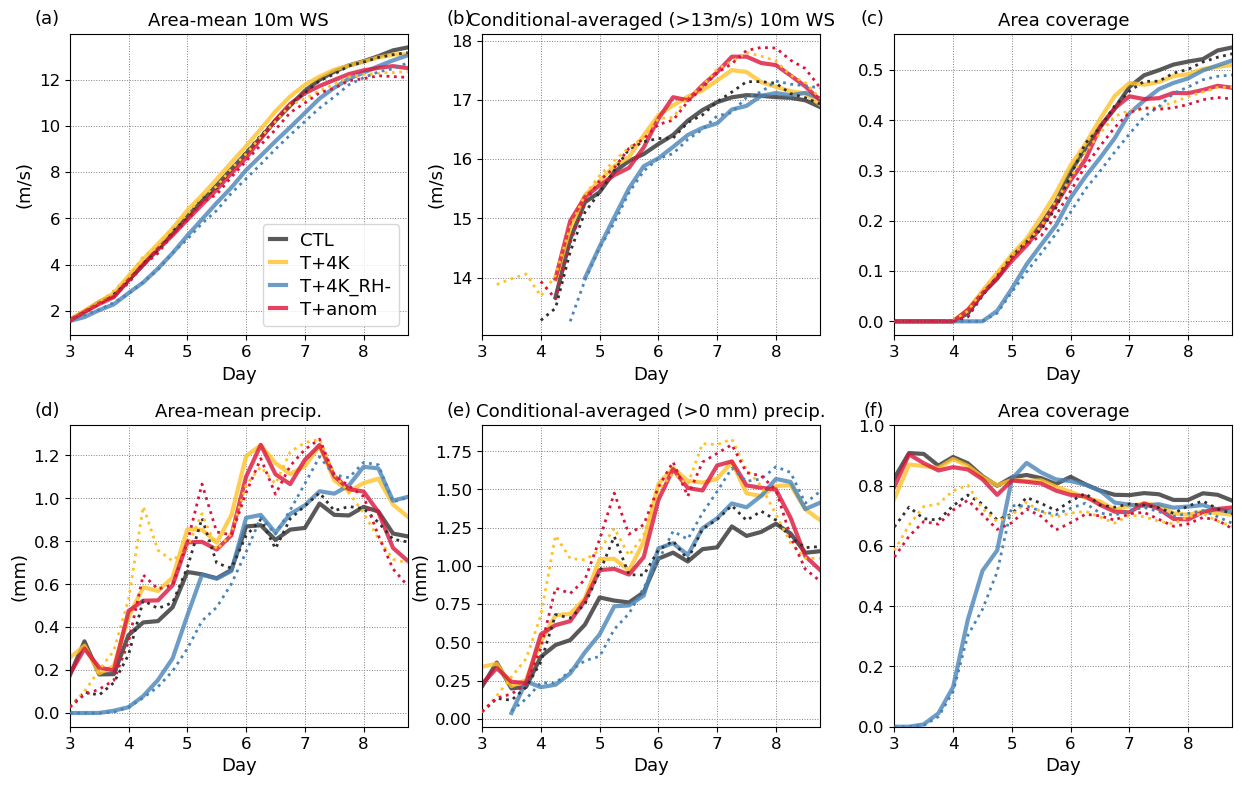

In [32]:
# FOR SUPPLEMENTARY MATERIAL ================================

colors2={0:'white',1:'#FFC125',2:'#4984b8',3:'crimson',4:'yellowgreen',5:'mediumpurple'}

#colors={1:'k',2:'#FFC125',3:'#4984b8',4:'crimson',5:'gold',6:'mediumseagreen'}
colors={0:'#303030',1:'#FFC125',2:'#4984b8',3:'crimson',4:'yellowgreen',5:'mediumpurple'}

colorsedge={0:'k',1:'k',2:'k',3:'k',4:'k',5:'k',6:'k'}
#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}



#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}
fs=12

plt.rcParams['savefig.facecolor']='white'
fig = plt.figure(figsize=(15, 9))


ax1 = plt.subplot(2,3,1)
for i in range(0,6,1): # 2km
    #if i > 3:
    #    plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    if i<=3: 
        plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1,zorder=100)
for i in range(6,12,1): # 80km
    #if i > 3+6:
    #    plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    if i<= 3+6:
        plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i-6],linewidth=3,alpha=0.8,label=expname[i-6]) 
        
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
#plt.ylim(1,13.8)
plt.xlabel('Day',fontsize=13)
plt.ylabel('(m/s)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Area-mean 10m WS', fontsize=13)
#plt.title('Averaged 850-m wdsp in 40x40 domain', fontsize=14)
plt.text(-0.03, 1.08, '(a)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
ax1.xaxis.set_ticks(np.arange(3, 9, 1))
plt.legend(loc="lower right",fontsize=13,labelspacing=0.28,handlelength=0.9)

ax1 = plt.subplot(2,3,2)
for i in range(0,6,1): # 2km
    #if i > 3:
    #    plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    if i<=3: 
        plt.plot(track_dur[experiments[i]],wdsp_cavg[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1,zorder=100)
for i in range(6,12,1): # 80km
    #if i > 3+6:
    #    plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    if i<= 3+6:
        plt.plot(track_dur[experiments[i]],wdsp_cavg[experiments[i]],color=colors[i-6],linewidth=3,alpha=0.8,label=expname[i-6]) 
        
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
#plt.ylim(1,13.8)
plt.xlabel('Day',fontsize=13)
plt.ylabel('(m/s)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Conditional-averaged (>13m/s) 10m WS', fontsize=13)
#plt.title('Averaged 850-m wdsp in 40x40 domain', fontsize=14)
plt.text(-0.03, 1.08, '(b)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
ax1.xaxis.set_ticks(np.arange(3, 9, 1))


ax1 = plt.subplot(2,3,3)
#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(0,6,1): # 2km
    #if i > 3:
    #    plt.plot(track_dur[experiments[i]],wdsp_ext[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    if i<=3: 
        plt.plot(track_dur[experiments[i]],wdsp_cgrid[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1,zorder=100)
for i in range(6,12,1): # 80km
    #if i > 3+6:
    #    plt.plot(track_dur[experiments[i]],wdsp_ext[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    if i<= 3+6:
        plt.plot(track_dur[experiments[i]],wdsp_cgrid[experiments[i]],color=colors[i-6],linewidth=3,alpha=0.8,label=expname[i-6]) 
      
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
#plt.ylim(0,1)
plt.xlabel('Day',fontsize=13)
#plt.ylabel('(m/s)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Area coverage', fontsize=13)
#plt.title('P98th 850-hPa wdsp in 40x40 domain', fontsize=14)
plt.text(-0.03, 1.08, '(c)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
#plt.legend(loc="lower right",fontsize=12,labelspacing=0.28,handlelength=0.9)
ax1.xaxis.set_ticks(np.arange(3, 9, 1))

#=============================================

ax1 = plt.subplot(2,3,4)
for i in range(0,6,1): # 2km
    #if i > 3:
    #    plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    if i <=3: 
        plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1,zorder=100)
for i in range(6,12,1): # 80km
    #if i > 3+6:
    #    plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    if i<= 3+6:
        plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i-6],linewidth=3,alpha=0.8,label=expname[i-6]) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
#plt.ylim(0, 1.3)
plt.xlabel('Day',fontsize=13)
plt.ylabel('(mm)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Area-mean precip.', fontsize=13)
plt.text(-0.03, 1.08, '(d)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
ax1.xaxis.set_ticks(np.arange(3, 9, 1))
#ax1.yaxis.set_ticks(np.arange(0, 1.3, 0.2))

ax1 = plt.subplot(2,3,5)
for i in range(0,6,1): # 2km
    #if i > 3:
    #    plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    if i <=3: 
        plt.plot(track_dur[experiments[i]],tp_cavg[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1,zorder=100)
for i in range(6,12,1): # 80km
    #if i > 3+6:
    #    plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    if i<= 3+6:
        plt.plot(track_dur[experiments[i]],tp_cavg[experiments[i]],color=colors[i-6],linewidth=3,alpha=0.8,label=expname[i-6]) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
#plt.ylim(0, 1.3)
plt.xlabel('Day',fontsize=13)
plt.ylabel('(mm)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Conditional-averaged (>0 mm) precip.', fontsize=13)
plt.text(-0.03, 1.08, '(e)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
ax1.xaxis.set_ticks(np.arange(3, 9, 1))
#ax1.yaxis.set_ticks(np.arange(0, 1.3, 0.2))

ax1 = plt.subplot(2,3,6)
#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(0,6,1): # 2km
    #if i > 3:
    #    plt.plot(track_dur[experiments[i]],tp_ext[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    if i <= 3: 
        plt.plot(track_dur[experiments[i]],tp_cgrid[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1,zorder=100)
for i in range(6,12,1): # 80km
    #if i > 3+6:
    #    plt.plot(track_dur[experiments[i]],tp_ext[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    if i<= 3+6:
        plt.plot(track_dur[experiments[i]],tp_cgrid[experiments[i]],color=colors[i-6],linewidth=3,alpha=0.8,label=expname[i-6]) 
        
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
plt.ylim(0, 1)
plt.xlabel('Day',fontsize=13)
#plt.ylabel('(mm)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Area coverage', fontsize=13)
plt.text(-0.03, 1.08, '(f)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
ax1.xaxis.set_ticks(np.arange(3, 9, 1))



plt.subplots_adjust(hspace = 0.3, wspace=0.22)

#plt.title('Deepening rate of the cyclone center (Semi-Lagragian)', fontsize=14)
#plt.savefig('FigR5_conditional_area.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()